In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

import itertools
import waterfall_chart

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## Przegląd danych

In [3]:
seed = 20

df = pd.read_stata('../data/HCMST 2017 fresh sample for public sharing draft v1.1.dta')
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Wybrane zmienne

* Numeryczne
    * age_when_met 
    * time_from_met_to_rel
<br><br>
* Kategoryczne
    * ppagecat
    * ppincimp

In [4]:
num_feature1 = 'age_when_met'  # age when met in years,
num_feature2 = 'time_from_met_to_rel'  # Time from meeting to relationship
cat_feature1 = 'ppagecat'  # Age - 7 Categories
cat_feature2 = 'ppincimp'  # Household Income 
label = 'S1'  # Are you married?

#### Zakodowanie danych kategorycznych

In [5]:
def encode_cat(column):
    le = LabelEncoder()
    encoded_col = le.fit_transform(column)
    return le, encoded_col

In [6]:
df = df[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()

le1, encoded_cat1 = encode_cat(df[cat_feature1])
le2, encoded_cat2 = encode_cat(df[cat_feature2])
df[cat_feature1] = encoded_cat1
df[cat_feature2] = encoded_cat2
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp,S1
0,30.0,0.000000,1,13,0
1,21.0,12.250000,4,5,1
2,36.0,0.416748,3,8,1
3,23.0,1.083252,1,13,0
4,25.0,0.083252,4,6,1


#### Podział na zbiory - treningowy i testowy

In [7]:
X = df.drop(label, axis=1)
y = df[label]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)

## Trening i walidacja modelu

In [8]:
model = xgb.sklearn.XGBClassifier(learning_rate=0.1, n_estimators=100, reg_lambda=1.5, random_state=seed)
model.fit(train_X.values, train_y.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=20, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [9]:
pred_y = model.predict(test_X.values)
score = accuracy_score(pred_y, test_y.values)
print(f'Accuracy: {(score*100):.2f}%')

Accuracy: 77.70%


## Wykresy

#### Funkcje do tworzenia wykresów 

In [10]:
def break_down(model, df, sample, order):
    df = df.copy()
    preds = [np.mean(model.predict_proba(df.values)[:, 1])]
    for var in order:
        val = sample[var].item()
        df[var] = val
        pred = np.mean(model.predict_proba(df.values)[:, 1])
        preds.append(pred)
    return [preds[i] - preds[i-1] if i != 0 else preds[i] for i in range(len(preds))]


def plot_break_down(model, df, sample, order, cat_cols):
    changes = break_down(model, df, sample, order)
    labels = ['intercept'] + [f'{o}={sample[o].item():.02f}' if o not in cat_cols else f'{o}={sample[o].item()}' for o in order]
    plot = waterfall_chart.plot(labels, changes, net_label='total', formatting='{:,.3f}')
    plot.rcParams["figure.figsize"] = (12, 5)
    
    
def shap_values(model, df, sample, features):
    all_changes = {f: [] for f in features}
    for order in itertools.permutations(features):
        changes = break_down(model, df, sample, order)
        for f, change in zip(order, changes[1:]):
            all_changes[f].append(change)
    return {f: np.mean(changes) for f, changes in all_changes.items()}


def plot_shap(model, df, sample, features, cat_cols):
    shap_dict = shap_values(model, df, sample, features)
    plt.figure(figsize=(12,5))
    labels, shap_vals = list(shap_dict.keys()), list(shap_dict.values())
    labels = [f'{l}={sample[l].item():.02f}' if l not in cat_cols else f'{l}={sample[l].item()}' for l in labels]
    plt.bar(range(len(labels)), shap_vals)
    plt.xticks(range(len(labels)), labels)

In [11]:
sample = train_X.sample(1, random_state=seed)
order1 = [num_feature1, num_feature2, cat_feature1, cat_feature2]
order2 = order1[::-1] 
sample

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp
982,35.0,0.083374,5,16


In [22]:
print(f'{cat_feature1}={sample[cat_feature1].item()}: {le1.classes_[sample[cat_feature1].item()]}')
print(f'{cat_feature2}={sample[cat_feature2].item()}: {le2.classes_[sample[cat_feature2].item()]}')

ppagecat=5: 65-74
ppincimp=16: $60,000 to $74,999


#### Break down #1

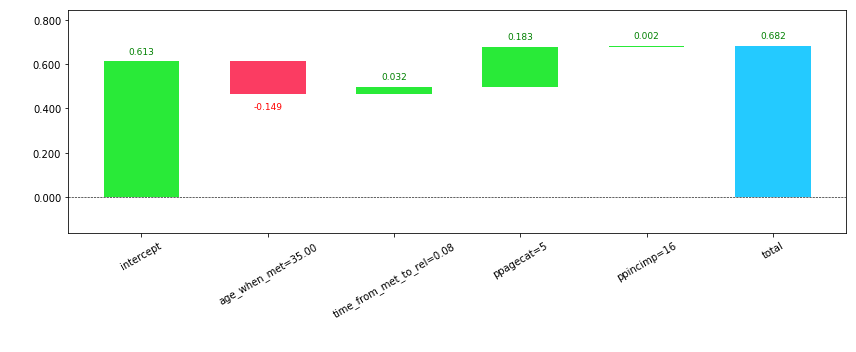

In [13]:
plot_break_down(model, train_X, sample, order1, cat_cols=[cat_feature1, cat_feature2])

#### Break down #2

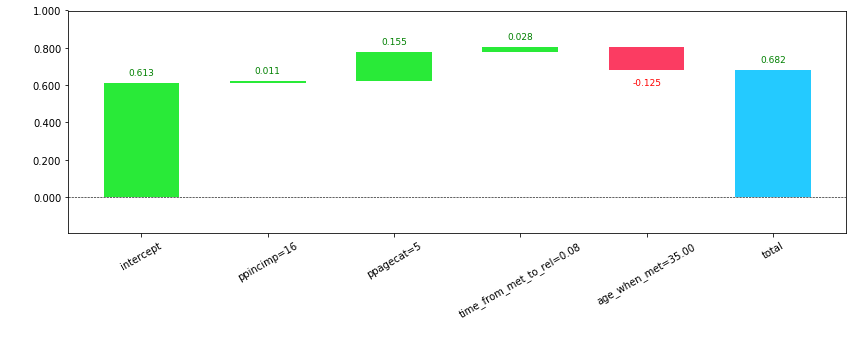

In [14]:
plot_break_down(model, train_X, sample, order2, cat_cols=[cat_feature1, cat_feature2])

#### SHAP

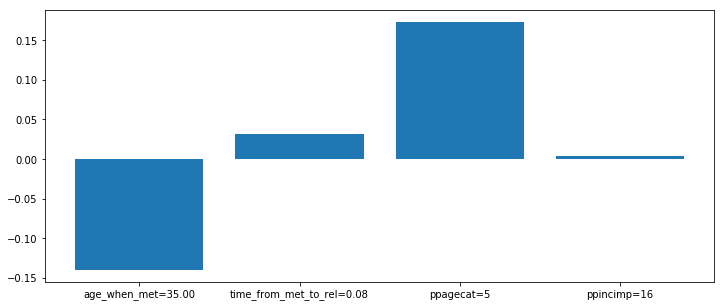

In [15]:
plot_shap(model, train_X, sample, order1, cat_cols=[cat_feature1, cat_feature2])

## Wnioski

Z wykresów break down wynika, że dla wybranego przypadku wartości dochodu oraz czasu od spotkania do związku nie zmieniają znacząco średniej predykcji dla całego zbioru. Widać to po małej zmianie bez względu na wybraną z 2 kolejności. Potwierdzają to wartości Shapleya dla tych zmiennych, które są relatywnie małe w porównaniu do 2 pozostałych. Wykresy wskazują, że wiek 65-74 wpływa pozytywnie na szansę bycia w związku małżeńskim, natomiast wiek 35 lat podczas pierwszego spotkania znacząco je obniża.
<br><br>
Oba wykresy break down przyjmują podobne wartości dla tych samych zmiennych bez względu na ich kolejność, co może oznaczać, że nie są od siebie szczególnie uzależnione  